In [1]:
hg19tohg38='http://hgdownload.soe.ucsc.edu/goldenPath/hg19/liftOver/hg19ToHg38.over.chain.gz'
#!CrossMap.py bigwig hg19ToHg38.over.chain.gz $y1 y1

In [1]:
import pandas as pd
import pyBigWig
import numpy as np
import seaborn as sns
import re
from liftover import get_lifter
data='/labs/mpsnyder/moqri/data/index/'

v='38'
h9_bw='http://smithdata.usc.edu/methbase/data/Xie-Human-2013/Human_H9/tracks_hg'+v+'/Human_H9.meth.bw'
ips_bw='http://smithdata.usc.edu/methbase/data/Lister-iPSC-2011/Human_FFiPSC69/tracks_hg'+v+'/Human_FFiPSC69.meth.bw'
ezh_pk='https://ftp.ncbi.nlm.nih.gov/geo/series/GSE76nnn/GSE76626/suppl/GSE76626_ChIP-Seq_RPM.txt.gz' ## hg38

ct_bw='http://smithdata.usc.edu/methbase/data/Heyn-Human-NewbornCentenarian-2012/Human_CD4T-100yr/tracks_hg'+v+'/Human_CD4T-100yr.meth.bw'
nb_bw='http://smithdata.usc.edu/methbase/data/Heyn-Human-NewbornCentenarian-2012/Human_CD4T-Newborn/tracks_hg'+v+'/Human_CD4T-Newborn.meth.bw'

def bw2df(cell,ch):
    df=bws[cell].intervals("chr"+str(ch))
    print(len(df))
    df=pd.DataFrame(df)
    df.index=df[0]
    df=df[2]
    dfs.append(df)    
    return(dfs)


In [2]:
ezh=pd.read_table('ezh2_38',skiprows=1)
ezh['chrom']=ezh.chrom.str.strip('chr')
ezh['chrom']=pd.to_numeric(ezh.chrom,errors='coerce')
ezh=ezh.dropna()
ezh['chrom']=ezh.chrom.astype(int).astype(str)
print(ezh.shape)
ezh['d']=ezh.chromEnd-ezh.chromStart
ezh.d.sum()/1000000

(25259, 9)


27.115971

In [19]:
ezh=pd.read_table(ezh_pk,index_col=0)
ezh=ezh[ezh.Chromosome!='MT']
ezh=ezh[['Chromosome','Start','End','WT_EZH2']][ezh['WT_EZH2']>2]
ezh.columns=['chrom', 'chromStart', 'chromEnd', 'value']
ezh['chrom']=ezh.chrom.astype(str)
print(ezh.shape)
ezh['d']=ezh.chromEnd-ezh.chromStart
ezh.d.sum()/1000000

(1219, 4)


/home/moqri/anaconda3/envs/stem/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


6.095

In [16]:
blood=[ips_bw,h9_bw,nb_bw,ct_bw]
#skin=[ips_bw,h9_bw,young_bw,old_bw]

In [17]:
cells=blood
bws={}
for cell in cells:
    bws[cell]=pyBigWig.open(cell)

/home/moqri/anaconda3/envs/stem/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


22
575094
576289
576289
576289


<ipython-input-20-6291a55c25fe>:14: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  df=pd.concat(dfs,1)


(2208, 6)


<ipython-input-20-6291a55c25fe>:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ez=df[df.h<.5][df['ez']]


<AxesSubplot:>

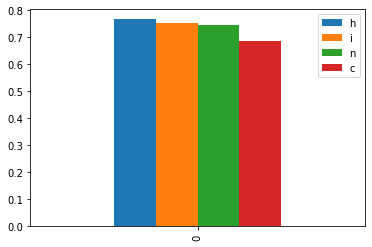

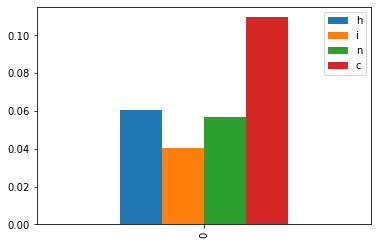

In [20]:
ggs=[]
ezs=[]
for ch in range(22,23):
    print(ch,end='\n')
    dfs=[]
    ez=ezh[ezh.chrom==str(ch)]
    #ez=ezh[ezh.chrom=='chr'+str(ch)][ezh.sourceCount>1]
    ez['r']=ez.apply(lambda x:range(x['chromStart'],x['chromEnd']),1)
    ez=ez['r'].tolist()
    ez1=set([item for sublist in ez for item in sublist])
    ez=ez1#.intersection(ez2)#.intersection(ez1)
    for cell in cells:
        dfs=bw2df(cell,ch)
    df=pd.concat(dfs,1)
    df.columns=['i','h','n','c']
    df['ind']=df.index
    df['ez']=df.ind.apply(lambda x: x in(ez))
    gg=df[~df['ez']].mean()
    ggs.append(gg)
    ez=df[df.h<.5][df['ez']]
    print(ez.shape)
    ezs.append(ez.mean())   
ggs=pd.DataFrame(ggs)
ggs[['h','i','n','c']].plot(kind='bar')
ezs=pd.DataFrame(ezs)
ezs[['h','i','n','c']].plot(kind='bar')
#ggs.to_csv('ggs_skin')
#ezs.to_csv('ezs_skin')

In [11]:
df=pd.read_table(data+'GSE52972_BS_dat.txt',sep=' ',nrows=100000000,usecols=['chr','start'],index_col=0)
df.shape

(1, 3)

In [ ]:
df['end']=df['start']

In [4]:
df.columns=['chrom','chromStart','chromEnd']

In [5]:
df.to_csv('hg19.txt',index=False,sep='\t',header=False)

In [6]:
!CrossMap.py bed hg19ToHg38.over.chain.gz hg19.txt hg38.txt

2021-11-12 01:55:19 [INFO]  Read the chain file "hg19ToHg38.over.chain.gz" 


In [7]:
un=pd.read_table('hg38.txt.unmap',header=None)
un.shape

(9262, 4)

In [8]:
un=un.drop(3,1)
un.columns=df.columns

<ipython-input-8-c847f56dbb89>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  un=un.drop(3,1)


In [9]:
un['un']=1

In [10]:
df=df.merge(un,how='left')

In [11]:
df=df[df.un!=1]

In [12]:
df=df.drop('un',1)

<ipython-input-12-bcd04c511161>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df=df.drop('un',1)


In [13]:
df.shape

(28208186, 3)

In [72]:
df.to_csv('index', columns=[], header=False)

In [2]:
cols=['Sample_E41','Sample_E43',
       'Sample_E45', 'Sample_E47', 'Sample_E49', 'Sample_E51',]# 'Sample_P41','Sample_P43', 'Sample_P45', 'Sample_P47', 'Sample_P49', 'Sample_P51']
df=pd.read_table(data+'GSE52972_BS_dat.txt',sep=' ',nrows=100000000,usecols=cols,index_col=0)
df.shape

(28217448, 6)

In [3]:
df=df.reset_index(drop=1)

In [4]:
ind=pd.read_table('index',index_col=0,header=None)

/home/moqri/anaconda3/envs/stem/lib/python3.9/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
df=df.loc[ind.index]

In [6]:
df.shape

(28208186, 6)

In [7]:
df38=pd.read_table('hg38.txt',header=None)
df38.shape

(28208186, 3)

In [8]:
df=df.reset_index(drop=1)

In [9]:
df[['chrom','chromStart']]=df38[[0,1]]

<AxesSubplot:xlabel='Sample_E41', ylabel='Sample_E43'>

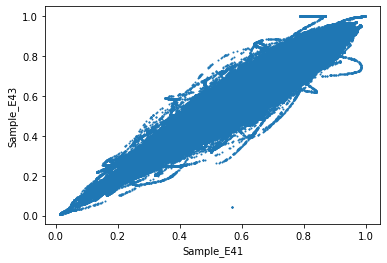

In [15]:
df[df.chrom=='chr6'][['Sample_E41','Sample_E43']].plot.scatter('Sample_E41','Sample_E43',s=1)

In [14]:
df[df.chrom=='chr6'][df.chromStart>11044685].sort_values('chromStart').head(50)

<ipython-input-14-b1811e13ad0f>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df.chrom=='chr6'][df.chromStart>11044685].sort_values('chromStart').head(50)


,Sample_E41,Sample_E43,Sample_E45,Sample_E47,Sample_E49,Sample_E51,chrom,chromStart
21297718,0.576762,0.537080,0.554169,0.635020,0.466186,0.462107,chr6,11044695
21297719,0.576781,0.537159,0.554194,0.635066,0.466158,0.462133,chr6,11044702
21297720,0.576803,0.537250,0.554223,0.635120,0.466127,0.462164,chr6,11044710
21297721,0.576847,0.537433,0.554282,0.635227,0.466065,0.462228,chr6,11044726
21297722,0.576873,0.537538,0.554315,0.635287,0.466031,0.462264,chr6,11044735
21297723,0.576891,0.537608,0.554338,0.635327,0.466008,0.462289,chr6,11044741
21297724,0.576969,0.537915,0.554438,0.635503,0.465914,0.462401,chr6,11044767
21297725,0.577140,0.538562,0.554652,0.635865,0.465737,0.462649,chr6,11044820
21297726,0.577323,0.539223,0.554877,0.636225,0.465583,0.462917,chr6,11044872
21297727,0.577360,0.539353,0.554922,0.636295,0.465556,0.462972,chr6,11044882


In [18]:
#df.to_csv('gse_38.csv')

In [63]:
    ch=22
    ez=ezh[ezh.chrom==str(ch)]
    #ez=ezh[ezh.chrom=='chr'+str(ch)][ezh.sourceCount>1]
    ez['r']=ez.apply(lambda x:range(x['chromStart'],x['chromEnd']),1)
    ez=ez['r'].tolist()
    ez1=set([item for sublist in ez for item in sublist])
    ez=ez1#.intersection(ez2)#.intersection(ez1)

/home/moqri/anaconda3/envs/stem/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [25]:
len(ez)

37891

In [28]:
df22=df[df.chrom=='chr22']

In [32]:
df22.drop(['chrom','chromStart'],1).mean()

<ipython-input-32-2c7e0faed2c6>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df22.drop(['chrom','chromStart'],1).mean()


Sample_E41    0.721100
Sample_E43    0.720897
Sample_E45    0.728847
Sample_E47    0.724254
Sample_E49    0.697396
Sample_E51    0.703287
dtype: float64

In [41]:
(df22[df22.chromStart.isin(ez)].mean()*100).astype(int)

<ipython-input-41-ea6b2310d1fa>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  (df22[df22.chromStart.isin(ez)].mean()*100).astype(int)


Sample_E41            34
Sample_E43            33
Sample_E45            35
Sample_E47            38
Sample_E49            37
Sample_E51            34
chromStart    3182344780
dtype: int64

In [52]:
ez2=df[df.h<.5][df['ez']].ind.values

<ipython-input-52-4cbfbee64c05>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ez2=df[df.h<.5][df['ez']].ind.values


In [60]:
ez2-1

array([19149018, 19149048, 19149062, ..., 45979351, 45979412, 45979414])

In [72]:
(df22[df22.chromStart.isin(np.array(list(ez))-1)].mean()*100).astype(int)

<ipython-input-72-569ab4fe939e>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  (df22[df22.chromStart.isin(np.array(list(ez))-1)].mean()*100).astype(int)


Sample_E41            34
Sample_E43            33
Sample_E45            35
Sample_E47            38
Sample_E49            37
Sample_E51            34
chromStart    3182854460
dtype: int64

array([41916988, 41916989, 41916990, ..., 45974038, 41916986, 41916987])

In [109]:
df22[df22.chromStart.isin(df[df.ez][df.h<.5].ind-1)]

<ipython-input-109-7e89752d625d>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df22[df22.chromStart.isin(df[df.ez][df.h<.5].ind-1)]


,Sample_E41,Sample_E43,Sample_E45,Sample_E47,Sample_E49,Sample_E51,chrom,chromStart
16028303,0.407700,0.393856,0.443941,0.492003,0.450320,0.391269,chr22,19149048
16028326,0.412402,0.399927,0.450990,0.498470,0.456517,0.397488,chr22,19149286
16028334,0.414845,0.402938,0.454425,0.501719,0.459500,0.400534,chr22,19149396
16028338,0.416533,0.404977,0.456730,0.503930,0.461489,0.402585,chr22,19149468
16028346,0.418389,0.407184,0.459211,0.506335,0.463620,0.404795,chr22,19149544
...,...,...,...,...,...,...,...,...
16458393,0.294984,0.263884,0.363195,0.366847,0.381660,0.353096,chr22,45979182
16458397,0.296046,0.264499,0.364467,0.367628,0.382118,0.354256,chr22,45979205
16458401,0.297301,0.265230,0.365969,0.368551,0.382659,0.355626,chr22,45979232
16458406,0.298659,0.266026,0.367592,0.369549,0.383242,0.357107,chr22,45979261


In [108]:
df[df.ez][df.h<.5]

<ipython-input-108-af701c2f48f3>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df.ez][df.h<.5]


,i,h,n,c,ind,ez
0,,,,,,
19149019,0.083333,0.315789,0.083333,0.166667,19149019,True
19149049,0.100000,0.400000,0.200000,0.200000,19149049,True
19149063,0.166667,0.461538,0.000000,0.181818,19149063,True
19149075,0.538462,0.454545,0.133333,0.105263,19149075,True
19149078,0.214286,0.260870,0.066667,0.187500,19149078,True
...,...,...,...,...,...,...
45979340,0.000000,0.100000,0.083333,0.000000,45979340,True
45979343,0.142857,0.000000,0.000000,0.000000,45979343,True
45979352,0.000000,0.000000,0.000000,0.000000,45979352,True


<AxesSubplot:>

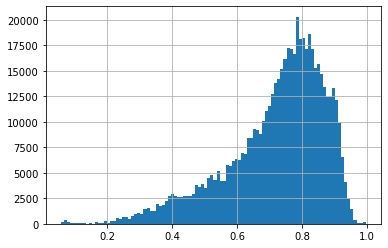

In [113]:
df22.iloc[:,0].hist(bins=100)

<AxesSubplot:>

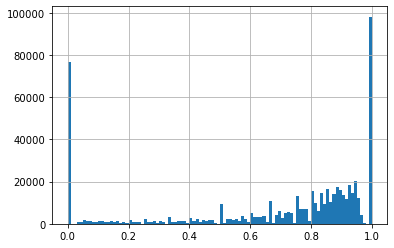

In [117]:
df.c.hist(bins=100)

In [120]:
df.corr()

,i,h,n,c,ind,ez
i,1.000000,0.841827,0.747890,0.705439,0.123279,-0.130248
h,0.841827,1.000000,0.783193,0.737298,0.121209,-0.130589
n,0.747890,0.783193,1.000000,0.826756,0.119037,-0.119460
c,0.705439,0.737298,0.826756,1.000000,0.111084,-0.101140
ind,0.123279,0.121209,0.119037,0.111084,1.000000,-0.017234
ez,-0.130248,-0.130589,-0.119460,-0.101140,-0.017234,1.000000


<AxesSubplot:xlabel='c', ylabel='n'>

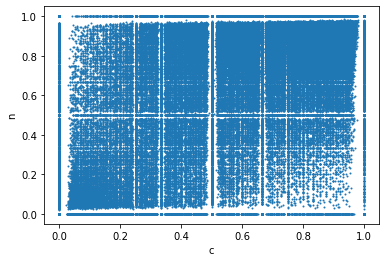

In [24]:
df[['n','c']].plot.scatter('c','n',s=1)